# We create necessary folders and .py files

In [37]:
import os

os.makedirs("utils", exist_ok=True)
os.makedirs("finbert_local", exist_ok=True)

In [38]:
#%%writefile utils/__init__.py

## Class for scrapping ecb press release list

In [39]:
%%writefile utils/ecb_scraper.py
import hashlib
import os
import re
import time
import pickle
import random
import asyncio
import aiohttp
import pandas as pd
import requests
from aiofiles import open as aio_open
from aiohttp import ClientError
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.common.exceptions import WebDriverException
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from urllib.parse import urljoin


class ECBScraper:
    """
    ECB Press Release Scraper with verbosity control
    - verbose=0: no printing
    - verbose=1: basic progress
    - verbose=2: full printing (success/failure for each article)
    """

    BASE_URL = "https://www.ecb.europa.eu"
    START_URL = (
        "https://www.ecb.europa.eu/press/pubbydate/html/index.en.html?"
        "name_of_publication=Press%20release"
    )

    def __init__(self, pickle_path="ecb_press_releases_df.pkl",
                 scroll_pause_time=0.1, scroll_increment=50,
                 max_scroll_attempts=None, initial_wait=10, verbose=1):
        self.pickle_path = pickle_path
        self.scroll_pause_time = scroll_pause_time
        self.scroll_increment = scroll_increment
        self.max_scroll_attempts = max_scroll_attempts
        self.initial_wait = initial_wait
        self.verbose = verbose
        self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
        self.existing_urls = set()
        self._load_data()

    # ------------------ Logging helpers ------------------
    def _log(self, msg, level=1):
        if self.verbose >= level:
            print(msg)

    def _log_progress(self, current, total):
        if self.verbose >= 1:
            print(f"📄 Scraped {current}/{total} articles")

    # ------------------ Pickle management -----------------
    def _load_data(self):
        if os.path.exists(self.pickle_path):
            try:
                self.df = pd.read_pickle(self.pickle_path)
                if not isinstance(self.df, pd.DataFrame):
                    raise ValueError("Pickle content invalid.")
                self.existing_urls = set(self.df["URL"].unique())
                self._log(f"✅ Loaded {len(self.df)} existing articles.", level=1)
            except Exception as e:
                self._log(f"⚠️ Error loading pickle: {e}. Starting fresh.", level=1)
                self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
                self.existing_urls = set()
        else:
            self._log(f"ℹ️ No pickle found, starting fresh.", level=1)
            self.df = pd.DataFrame(columns=["Date", "Title", "URL"])
            self.existing_urls = set()

    def _save_data(self):
        if not self.df.empty:
            self.df.to_pickle(self.pickle_path)
            self._log(f"💾 Saved {len(self.df)} articles → {self.pickle_path}", level=1)

    # ------------------ Scraping --------------------------
    def _setup_driver(self):
        try:
            options = webdriver.ChromeOptions()
            options.add_argument("--headless")
            options.add_argument("--disable-gpu")
            options.add_argument("--no-sandbox")
            service = ChromeService(ChromeDriverManager().install())
            return webdriver.Chrome(service=service, options=options)
        except WebDriverException as e:
            self._log(f"❌ WebDriver setup error: {e}", level=1)
            return None

    def _scroll_page(self, driver):
        self._log("📜 Scrolling page...", level=1)
        attempt = 0
        while True:
            last_scroll_position = driver.execute_script("return window.pageYOffset;")
            driver.execute_script(f"window.scrollBy(0, {self.scroll_increment});")
            time.sleep(self.scroll_pause_time)
            new_scroll_position = driver.execute_script("return window.pageYOffset;")
            if new_scroll_position == last_scroll_position:
                self._log("✅ Reached page bottom.", level=1)
                break
            attempt += 1
            if self.max_scroll_attempts and attempt >= self.max_scroll_attempts:
                self._log("⚠️ Max scroll attempts reached.", level=1)
                break

    def _extract_articles(self, html_content):
        soup = BeautifulSoup(html_content, "html.parser")
        main_content = soup.find("div", id="ecb-content-col") or soup.find("main")
        if not main_content:
            self._log("⚠️ Could not find main content section.", level=1)
            return []

        articles = []
        current_date = None
        sort_wrapper = main_content.find("div", class_="sort-wrapper")
        if not sort_wrapper:
            self._log("⚠️ No sort-wrapper found.", level=1)
            return []

        dl = sort_wrapper.find("dl", recursive=False)
        if not dl:
            self._log("⚠️ No <dl> in sort-wrapper.", level=1)
            return []

        for tag in dl.find_all(["dt", "dd"], recursive=False):
            if tag.name == "dt":
                current_date = tag.get_text(strip=True)
            elif tag.name == "dd" and current_date:
                cat_div = tag.find("div", class_="category")
                title_div = tag.find("div", class_="title")
                if not (cat_div and title_div):
                    continue
                if cat_div.get_text(strip=True) != "Press release":
                    continue
                link_tag = title_div.find("a", href=True)
                if not link_tag:
                    continue
                url = urljoin(self.BASE_URL, link_tag["href"])
                if "/press/pr/" not in url:
                    continue
                title = link_tag.get_text(strip=True)
                articles.append({"Date": current_date, "Title": title, "URL": url})
        return articles

    def scrape_and_update(self):
        driver = self._setup_driver()
        if not driver:
            return

        try:
            self._log(f"🌐 Navigating to {self.START_URL}", level=1)
            driver.get(self.START_URL)
            time.sleep(self.initial_wait)
            self._scroll_page(driver)
            html = driver.page_source
        except Exception as e:
            self._log(f"❌ Error scraping: {e}", level=1)
            return
        finally:
            driver.quit()

        articles = self._extract_articles(html)
        self._log(f"📰 Found {len(articles)} articles total.", level=1)
        new_articles = [a for a in articles if a["URL"] not in self.existing_urls]

        if not new_articles:
            self._log("ℹ️ No new articles found.", level=1)
            return

        new_df = pd.DataFrame(new_articles)
        self.df = pd.concat([new_df, self.df]).drop_duplicates("URL", keep="first").reset_index(drop=True)
        self.existing_urls.update(new_df["URL"])
        self._save_data()
        self._log(f"✅ Added {len(new_articles)} new articles.", level=1)

    # ------------------ Async fetching -------------------
    async def _fetch_article(self, session, url, retries=3):
        """
        Fetch the text content of one article from its URL asynchronously.
        Preserves the order of <h1>, <h3>, <p>, <ul>/<ol> and relevant <div> across <main>,
        while ignoring full divs like 'address-box -top-arrow' and 'see-also-boxes'.
        Avoids duplicated text.
        """
        for attempt in range(retries):
            try:
                async with session.get(url, timeout=20) as resp:
                    if resp.status != 200:
                        raise aiohttp.ClientError(f"Status {resp.status}")
                    html = await resp.text()
                    soup = BeautifulSoup(html, "html.parser")

                    main = soup.find("main")
                    if not main:
                        return ""

                    # Remove unwanted sections
                    for div in main.find_all("div", class_=["address-box", "-top-arrow", "see-also-boxes"]):
                        div.decompose()

                    content = []
                    seen_text = set()

                    # Add main headline <h1> first
                    h1 = main.find("h1", class_="ecb-pressContentTitle")
                    if h1:
                        text = h1.get_text(strip=True)
                        if text:
                            content.append(text)
                            seen_text.add(text)

                    # Traverse all sections individually
                    for section in main.find_all("div", class_="section"):
                        for element in section.find_all(["h3", "p", "ul", "ol"], recursive=True):
                            if element.name in ["h3", "p"]:
                                text = element.get_text(strip=True)
                                if text and text not in seen_text:
                                    content.append(text)
                                    seen_text.add(text)
                            elif element.name in ["ul", "ol"]:
                                for li in element.find_all("li"):
                                    li_text = li.get_text(strip=True)
                                    if li_text and li_text not in seen_text:
                                        content.append(f"• {li_text}")
                                        seen_text.add(li_text)

                    return "\n\n".join(content).strip()

            except Exception as e:
                wait = 2 ** attempt + random.uniform(0, 0.5)
                self._log(f"⚠️ Error fetching {url} ({e}), retrying in {wait:.1f}s...", level=2)
                await asyncio.sleep(wait)

        self._log(f"❌ Failed to fetch {url} after {retries} retries.", level=2)
        return ""

    async def _save_article(self, semaphore, session, row, folder):
        async with semaphore:
            title, url = row.Title, row.URL
            date = str(row.Date)
            safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)

            # Add formatted date string (year_monthname_day)
            parts = date.split()
            if len(parts) >= 3:
                day, month, year = parts[0], parts[1], parts[2]
                date_str = f"{year}_{month}_{day}"
            else:
                date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"

            if len(safe_title) > 230:
                safe_title = safe_title[:230]
            safe_title = f"{safe_title}_{date_str}"

            file_path = os.path.join(folder, f"{safe_title}.txt")

            if os.path.exists(file_path):
                if self.verbose == 2:
                    self._log(f"⏩ Skipping '{title}' (already saved)", level=2)
                return

            try:
                text = await self._fetch_article(session, url)
                if not text or not text.strip():
                    if self.verbose >= 2:
                        self._log(f"⚠️ Skipping '{title}' (fetch failed or empty content)", level=2)
                    return

                async with aio_open(file_path, "w", encoding="utf-8") as f:
                    await f.write(text)

                if self.verbose == 2:
                    self._log(f"✅ Saved '{title}'", level=2)

            except Exception as e:
                if self.verbose >= 2:
                    self._log(f"⚠️ Fetch failed for '{title}' ({e}), no file created.", level=2)


    async def scrape_all_texts_to_files_async(self, folder="ecb_press_release", concurrency=6):
        """
        Scrape all articles in self.df and save them as text files asynchronously.
        The final count of saved articles is computed by counting files in the folder.
        """
        os.makedirs(folder, exist_ok=True)
        n = len(self.df)

        headers = {
            "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                        "AppleWebKit/537.36 (KHTML, like Gecko) "
                        "Chrome/118.0 Safari/537.36"
        }

        semaphore = asyncio.Semaphore(concurrency)
        connector = aiohttp.TCPConnector(limit_per_host=concurrency, force_close=True)

        async with aiohttp.ClientSession(headers=headers, connector=connector) as session:
            tasks = [self._save_article(semaphore, session, row, folder)
                    for row in self.df.itertuples(index=False)]
            await asyncio.gather(*tasks)

        # Count saved files in folder
        saved_count = len([f for f in os.listdir(folder) if f.endswith(".txt")])
        self._log(f"📄 Scraped {saved_count}/{n} articles successfully", level=1)
        self._log(f"🎉 All texts attempted to save in '{folder}/'", level=1)
        
    # ------------------ Async fetching (summaries only) -------------------
    async def _fetch_article_summary(self, session, url, retries=3):
        """
        Fetch only the summary part of an ECB press release.
        - Normally takes the first <ul> inside <main>.
        - If the first <ul> contains an <li> with text including 'PRESS RELEASE',
          then takes the second <ul> instead.
        - Some articles does not have summary at the begining si it's finally not suitable for our project.
        """
        for attempt in range(retries):
            try:
                async with session.get(url, timeout=20) as resp:
                    if resp.status != 200:
                        raise aiohttp.ClientError(f"Status {resp.status}")
                    html = await resp.text()
                    soup = BeautifulSoup(html, "html.parser")

                    main = soup.find("main")
                    if not main:
                        return ""

                    # Remove irrelevant divs
                    for div in main.find_all("div", class_=["address-box", "-top-arrow", "see-also-boxes"]):
                        div.decompose()

                    # Find all <ul> inside <main>
                    uls = [
                        ul for ul in main.find_all("ul", recursive=True)
                        if not any(x in (ul.get("class") or []) for x in ["social", "breadcrumb"])
                    ]
                    if not uls:
                        return ""

                    chosen_ul = uls[0]

                    # Check if the first UL has an LI containing "PRESS RELEASE"
                    first_ul_texts = [li.get_text(strip=True).upper() for li in uls[0].find_all("li")]
                    if any("PRESS RELEASE" in t for t in first_ul_texts) and len(uls) > 1:
                        chosen_ul = uls[1]

                    summary_points = []
                    seen_text = set()

                    # Only take direct li children (not nested)
                    for li in chosen_ul.find_all("li", recursive=False):
                        li_text = li.get_text(strip=True)
                        if li_text and li_text not in seen_text:
                            summary_points.append(f"• {li_text}")
                            seen_text.add(li_text)

                    return "\n".join(summary_points).strip()

            except Exception as e:
                wait = 2 ** attempt + random.uniform(0, 0.5)
                self._log(f"⚠️ Error fetching summary {url} ({e}), retrying in {wait:.1f}s...", level=2)
                await asyncio.sleep(wait)

        self._log(f"❌ Failed to fetch summary {url} after {retries} retries.", level=2)
        return ""

    async def _save_summary(self, semaphore, session, row, folder):
        async with semaphore:
            title, url = row.Title, row.URL
            date = str(row.Date)
            safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)

            # Add formatted date string (year_monthname_day)
            parts = date.split()
            if len(parts) >= 3:
                day, month, year = parts[0], parts[1], parts[2]
                date_str = f"{year}_{month}_{day}"
            else:
                date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"

            if len(safe_title) > 230:
                safe_title = safe_title[:230]
            safe_title = f"{safe_title}_{date_str}"

            file_path = os.path.join(folder, f"{safe_title}.txt")

            if os.path.exists(file_path):
                if self.verbose == 2:
                    self._log(f"⏩ Skipping summary '{title}' (already saved)", level=2)
                return

            try:
                summary = await self._fetch_article_summary(session, url)
                if not summary or not summary.strip():
                    if self.verbose >= 2:
                        self._log(f"⚠️ Skipping summary '{title}' (fetch failed or empty content)", level=2)
                    return

                async with aio_open(file_path, "w", encoding="utf-8") as f:
                    await f.write(summary)

                if self.verbose == 2:
                    self._log(f"✅ Saved summary '{title}'", level=2)

            except Exception as e:
                if self.verbose >= 2:
                    self._log(f"⚠️ Fetch failed for summary '{title}' ({e}), no file created.", level=2)

    async def scrape_all_summaries_to_files_async(self, folder="ecb_press_release_summary", concurrency=6):
        """
        Scrape only the summaries (first <ul> list inside main) of all articles in self.df
        and save them as text files asynchronously.
        """
        os.makedirs(folder, exist_ok=True)
        n = len(self.df)

        headers = {
            "User-Agent": (
                "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
                "AppleWebKit/537.36 (KHTML, like Gecko) "
                "Chrome/118.0 Safari/537.36"
            )
        }

        semaphore = asyncio.Semaphore(concurrency)
        connector = aiohttp.TCPConnector(limit_per_host=concurrency, force_close=True)

        async with aiohttp.ClientSession(headers=headers, connector=connector) as session:
            tasks = [self._save_summary(semaphore, session, row, folder)
                     for row in self.df.itertuples(index=False)]
            await asyncio.gather(*tasks)

        saved_count = len([f for f in os.listdir(folder) if f.endswith(".txt")])
        self._log(f"📄 Saved {saved_count}/{n} summaries successfully", level=1)
        self._log(f"🎉 All summaries attempted to save in '{folder}/'", level=1)

Overwriting utils/ecb_scraper.py


## Class for loading and use finbert model

FinBERTLoader is a class that loads the FinBERT model from ProsusAI along with its tokenizer. If the model is already available locally, it loads it from disk; otherwise, it downloads it from Hugging Face.

FinBERTLoader can also apply FinBERT to a text after splitting it into smaller chunks. Since FinBERT was trained for sentence-level classification, the class provides the method clean_and_filter_sentences to split a text into sentences. Although FinBERT was trained on sentences, its maximum token length is 512, which is much larger than a typical sentence. Therefore, one idea is to split the text into paragraphs instead, in order to explore the trade-off between providing training-like inputs and providing more contextual information. It is also possible to split the text directly into 512-token subtexts.

The method text_to_dic takes a text and a chosen splitting strategy, and returns a dictionary with the keys positivity, negativity, neutrality, and nb_token. These correspond to the lists of FinBERT logits for each chunk of text, as well as the number of tokens for each chunk.

The method returns logits on purpose: if probabilities are needed for the k-th element, a softmax can be applied to the k-th values of the positivity, negativity, and neutrality lists.



In [40]:
%%writefile utils/finbert_loader.py
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import os
import re
import nltk


class FinBERTLoader:
    """
    Class to manage loading and saving of FinBERT model and tokenizer.
    Handles automatic downloading or loading from local storage.
    """
    
    def __init__(self, model_name="ProsusAI/finbert", local_dir="./finbert_local"):
        """
        Initialize the FinBERT loader.
        
        Args:
            model_name (str): HuggingFace model name
            local_dir (str): Directory to save/load the model locally
        """
        self.model_name = model_name
        self.local_dir = local_dir
        self.model = None
        self.tokenizer = None
        
    def load(self):
        """
        Load the model and tokenizer, either from local storage if available,
        or download from HuggingFace if not.
        """
        if self._is_model_cached():
            print("Loading FinBERT from local storage...")
            self.model = AutoModelForSequenceClassification.from_pretrained(self.local_dir)
            self.tokenizer = AutoTokenizer.from_pretrained(self.local_dir)
        else:
            print("Downloading FinBERT from HuggingFace...")
            self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self._save_local()
            
        print("FinBERT loaded successfully!")
        return self
    
    def _is_model_cached(self):
        """Check if model files exist in local directory."""
        return os.path.exists(self.local_dir) and os.path.exists(os.path.join(self.local_dir, "config.json"))
    
    def _save_local(self):
        """Save model and tokenizer to local directory."""
        print("Saving model locally for future use...")
        os.makedirs(self.local_dir, exist_ok=True)
        self.model.save_pretrained(self.local_dir)
        self.tokenizer.save_pretrained(self.local_dir)

    def _chunk_text(self, tokens, max_length=512):
        """Helper to split tokens into chunks of max_length."""
        for i in range(0, len(tokens), max_length):
            chunk = tokens[i:i + max_length]
            yield chunk

    def _from_text_to_tokens(self, text):
        """
        Tokenize the input text using the FinBERT tokenizer.
        For texts longer than 512 tokens (whiwh append when we put the whole text), splits into chunks.
        Returns list of tokenized inputs suitable for the model.
        """
        if not self.tokenizer:
            raise RuntimeError("Tokenizer not loaded. Call load() first.")
            
        # First encode without special tokens to get raw tokens
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        
        # If text is short enough, process normally
        if len(tokens) <= 512:
            return [self.tokenizer(text, return_tensors="pt", truncation=True, 
                                 max_length=512, padding=True)]
        
        # For long texts, split into chunks
        all_inputs = []
        for chunk in self._chunk_text(tokens):
            # Decode chunk back to text and re-encode properly with special tokens
            chunk_text = self.tokenizer.decode(chunk)
            inputs = self.tokenizer(chunk_text, return_tensors="pt", 
                                  truncation=True, max_length=512, padding=True)
            all_inputs.append(inputs)
            
        return all_inputs

    def text_to_dic(self, text, splitting_method='lines'):
        """
        Analyze the sentiment of the input text using FinBERT.
        Can split the text into sentences or lines before analysis."""

        if not self.model or not self.tokenizer:
            raise RuntimeError("Model not loaded. Call load() first.")
            
        dic = {'positivity': [], 'negativity': [], 'neutrality': [], 'nb_token': []}
        if splitting_method == 'sentences':
            sub_texts = self.clean_and_filter_sentences(text)
        elif splitting_method == 'lines':
            sub_texts = self.clean_and_filter_lines(text)
        else:
            sub_texts = [text]
        for line in sub_texts:
            inputs_list = self._from_text_to_tokens(line)
            all_logits = []
        
            
            for inputs in inputs_list:
                outputs = self.model(**inputs)
                logits = outputs.logits
                dic['positivity'].append(logits[0][0].item())
                dic['negativity'].append(logits[0][1].item())
                dic['neutrality'].append(logits[0][2].item())
                dic['nb_token'].append(inputs['input_ids'].shape[1])
        return(dic)
    
    @staticmethod
    def ensure_punkt_downloaded():
        """Ensure both punkt and punkt_tab are installed."""
        resources = ['punkt', 'punkt_tab']
        for res in resources:
            try:
                nltk.data.find(f'tokenizers/{res}')
            except LookupError:
                nltk.download(res)

    @staticmethod
    def clean_and_filter_lines(text):
        """
        Split a text into lines, clean them, and remove irrelevant ones."""
        lines = text.split('\n')
        
        cleaned_lines = []
        for line in lines:
            line = line.strip()
            if not line:
                continue
            if len(line) < 40:
                continue
            if re.match(r'^[\d\-\s\+\(\)]+$', line):  
                continue
            if line.lower().startswith('sources: '):
                continue  
            cleaned_lines.append(line)
        
        return cleaned_lines

    @staticmethod
    def clean_and_filter_sentences(text):
        """
        Split a text into sentences, clean them, and remove irrelevant ones."""
        lines = FinBERTLoader.clean_and_filter_lines(text)

        FinBERTLoader.ensure_punkt_downloaded()
        cleaned_sentences = []
        for line in lines:
            # 1. Split text into sentences using NLTK's trained tokenizer
            sentences = nltk.sent_tokenize(line)

        
            for sent in sentences:
                # Remove leading/trailing whitespace
                sent = sent.strip()

                # Skip empty sentences
                if not sent:
                    continue

                # Skip very short fragments (not meaningful)
                if len(sent) < 10:
                    continue

                # Skip lines containing only digits, dashes, or parentheses (e.g. phone numbers)
                if re.match(r'^[\d\-\s\+\(\)]+$', sent):
                    continue

                # Skip source lines or metadata
                if sent.lower().startswith("sources:"):
                    continue

                # Normalize spacing
                sent = re.sub(r'\s+', ' ', sent)

                cleaned_sentences.append(sent)

        return cleaned_sentences



Overwriting utils/finbert_loader.py


# Required import

In [41]:
import re
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from utils.ecb_scraper import ECBScraper

# Ad hoc functions

In [42]:
def make_safe_title(row):
    """
    This function take a row of the dataframe contaning all the press release with titles and date of press releases 
    and return the name of the file we used to save the text of the press release.
    """
    title = str(row['Title'])
    date = str(row.get('Date', 'unknown'))
    safe_title = re.sub(r"[^a-zA-Z0-9 _-]", "_", title)
    
    # Extract year, month (in letters), and day if possible
    parts = date.split()
    if len(parts) >= 3:
        day, month, year = parts[0], parts[1], parts[2]
        date_str = f"{year}_{month}_{day}"
    else:
        date_str = re.sub(r"[^0-9]", "", date)[:8] or "unknown"
    
    if len(safe_title) > 230:
        safe_title = safe_title[:230]
    safe_title = f"{safe_title}" + '_' + date_str
    return safe_title

def get_aligned_returns(ticker, freq="W", start=None, end=None, ref_df=None):
    """
    Download returns for a given ticker and align them with an existing DataFrame (e.g. weekly_avg),
    then shift the aligned returns to the next period to avoid look-ahead bias, keeping both date_return
    and return aligned.

    Parameters
    ----------
    ticker : str
        Ticker symbol (e.g. '^STOXX50E', '^FCHI', '^GDAXI').
    freq : str, optional
        Frequency for returns: 'W', '2W', 'M', etc.
    start : str or None
        Start date for historical data.
    end : str or None
        End date for historical data.
    ref_df : pd.DataFrame or None
        Reference DataFrame with a datetime column (e.g. 'Date_parsed') to align on.

    Returns
    -------
    aligned_df : pd.DataFrame
        Reference DataFrame with aligned returns shifted forward to next period,
        keeping both date_return and return correctly aligned.
    """

    # --- Download data ---
    dat = yf.Ticker(ticker)
    data = dat.history(period="max" if start is None and end is None else None,
                       start=start, end=end)
    
    if data.empty:
        raise ValueError(f"No data found for ticker {ticker}")
    
    data = data[["Close"]].copy()
    data.index = pd.to_datetime(data.index)
    
    # --- Resample to desired frequency ---
    data_resampled = data.resample(freq).last()
    
    # --- Compute returns ---
    data_resampled["Return"] = data_resampled["Close"].pct_change()
    data_resampled = data_resampled.reset_index().rename(columns={"Date": "date_return"})
    data_resampled["date_return"] = data_resampled["date_return"].dt.strftime("%Y-%m-%d")
    
    # --- Align with reference DataFrame ---
    if ref_df is not None:
        ref_df_copy = ref_df.copy()
        ref_df_copy["Date_parsed"] = pd.to_datetime(ref_df_copy["Date_parsed"]).dt.strftime("%Y-%m-%d")
        
        aligned = pd.merge(
            ref_df_copy,
            data_resampled[["date_return", "Return"]],
            left_on="Date_parsed",
            right_on="date_return",
            how="left"
        )
        
        # --- Shift after joining to get next-period returns ---
        aligned[["date_return", "Return"]] = aligned[["date_return", "Return"]].shift(-1)
        
        return aligned
    else:
        # Shift even if no ref_df
        data_resampled[["date_return", "Return"]] = data_resampled[["date_return", "Return"]].shift(-1)
        return data_resampled[["date_return", "Return"]]
    


def dic_to_score_proba(dic, token_weighted = True, treshold = 0):
    def softmax(x):
        e_x = torch.exp(x - torch.max(x))
        return e_x / e_x.sum(dim=0)
    total = 0
    sum_score = 0
    for i in range(len(dic['positivity'])):
        logits = torch.tensor([dic['positivity'][i], dic['negativity'][i], dic['neutrality'][i]])
        probs = softmax(logits)
        if probs[2]> treshold:
            continue
        else:
            score = probs[1] - probs[0]
            if token_weighted:
                score = score * dic['nb_token'][i]
            sum_score += score
            if token_weighted:
                total += dic['nb_token'][i]
            else:
                total += 1
    if total > 0:
        final_score = sum_score / total
    else:
        return(0)
    return(final_score.item())


def dic_to_score_logits(dic, token_weighted = True, treshold = 0):
        total = 0
        sum_score = 0
        for i in range(len(dic['positivity'])):
            if dic['neutrality'][i]> treshold:
                continue
            score = dic['negativity'][i] - dic['positivity'][i]
            if token_weighted:
                score = score * dic['nb_token'][i]
            sum_score += score
            if token_weighted:
                total += dic['nb_token'][i]
            else:
                total += 1
        if total > 0:
            final_score = sum_score / total
        else:
            return(0)
        return(final_score)
def dic_to_proba_as_article(dic):
    def softmax(x):
        e_x = torch.exp(x - torch.max(x))
        return e_x / e_x.sum(dim=0)
    score = 0
    for i in range(len(dic['positivity'])):
        logits = torch.tensor([dic['positivity'][i], dic['negativity'][i], dic['neutrality'][i]])
        probs = softmax(logits)
        score += probs[1]
    if  len(dic['positivity']) == 0:
        return(0)
    score = score / len(dic['positivity'])
    return(score.item())

def nb_tokens_total(dic):
    total = 0
    for i in range(len(dic['positivity'])):
        total += dic['nb_token'][i]
    return(total)

    

# We scrapp all ecb press release adress and download each press release in .txt file

In [43]:
scraper = ECBScraper(pickle_path="ecb_press_releases_link_df.pkl", verbose=1)

if scraper.df.empty:
    scraper.scrape_and_update()

await scraper.scrape_all_texts_to_files_async(concurrency=10)
# await scraper.scrape_all_summaries_to_files_async(concurrency=10)

✅ Loaded 2142 existing articles.
📄 Scraped 2130/2142 articles successfully
🎉 All texts attempted to save in 'ecb_press_release/'


# Finbert downloading

In [44]:
from utils.finbert_loader import FinBERTLoader

finbert = FinBERTLoader().load()

# Exemple
text = "ECB reports strong economic growth in the eurozone"
result = finbert.text_to_dic(text)
print(f"Sentiment Analysis Result: {result}")

Loading FinBERT from local storage...
FinBERT loaded successfully!
Sentiment Analysis Result: {'positivity': [2.103879690170288], 'negativity': [-1.9270817041397095], 'neutrality': [-1.4829474687576294], 'nb_token': [12]}


In [45]:
import os
import re
from pathlib import Path
import hashlib

folder = "ecb_press_release"
def make_dictionary_from_title(row, fin, splitting_method='lines'):
  safe_title = row['title_file']
  file_path = os.path.join(folder, f"{safe_title}.txt")
  if os.path.exists(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        dic = fin.text_to_dic(text, splitting_method=splitting_method)

    return dic
  else:
    return {'positivity': None, 'negativity': None, 'neutrality': None, 'nb_token': 0}


def make_score(row, fin, score_function, dictionary_name='dictionary'):
  dic = row[dictionary_name]
  if dic['nb_token'] == 0:
      return 0
  score = score_function(dic)
  return score



In [46]:
import os
import re
from pathlib import Path


outdir = Path.cwd()
outdir.mkdir(parents=True, exist_ok=True)
pickle_path = outdir / "df_score_by_article_all_dictionary.pkl"

if not pickle_path.exists():
    folder = "ecb_press_release"
    finbert = FinBERTLoader().load()
    df_dic_by_article = pd.read_pickle("ecb_press_releases_link_df.pkl")#.iloc[:10]
    df_dic_by_article['title_file'] = df_dic_by_article.apply(make_safe_title, axis=1)
    df_dic_by_article['dictionary_lines'] = df_dic_by_article.apply(lambda row: make_dictionary_from_title(row, finbert, splitting_method = 'lines'), axis=1)
    df_dic_by_article['dictionary_sentences'] = df_dic_by_article.apply(lambda row: make_dictionary_from_title(row, finbert, splitting_method = 'sentences'), axis=1)
    df_dic_by_article['dictionary'] = df_dic_by_article.apply(lambda row: make_dictionary_from_title(row, finbert, splitting_method = 'None'), axis=1)
    df_dic_by_article.to_pickle(pickle_path)
    print(f"✅ Sauvegardé → {pickle_path}")

else:
    print(f"ℹ️ Le fichier {pickle_path} existe déjà")
    df_dic_by_article = pd.read_pickle(pickle_path)

ℹ️ Le fichier d:\Documents\3A\Projet ML for trading\df_score_by_article_all_dictionary.pkl existe déjà


### Sentiment Scoring Methods

Several scoring functions are implemented to transform the FinBERT output dictionary into global sentiment indicators. Each dictionary contains, for every text chunk $i$, the logits:

$$
(\ell^{(i)}_{\text{pos}},\ \ell^{(i)}_{\text{neg}},\ \ell^{(i)}_{\text{neu}})
$$

and the corresponding token count $n^{(i)}$.

we can converts logits into probabilities using a softmax:

$$
p^{(i)}_k = \frac{e^{\ell^{(i)}_k}}{\sum_j e^{\ell^{(i)}_j}}
$$

---


#### 1. Mean negative probability

The function `dic_to_proba_as_article` returns the average negative probability:

$$
S_{\text{neg}} = \frac{1}{N} \sum_i p^{(i)}_{\text{neg}}
$$

This score is the one used in the article, so we can consider it as our baseline. The main criticisms are that it does not take the positivity of the text into account, and that very negative information can be diluted by neutral content and therefore may not be reflected in the score.


---

#### 2. Probability-based sentiment score

The function `dic_to_score_proba` look for each chunk that is not too neutral ( $p^{(i)}_{\text{neu}} \leq \text{threshold}$ = 0.5 ).

For each chunk that meets the condition, a score is defined:

$$
s^{(i)} = p^{(i)}_{\text{neg}} - p^{(i)}_{\text{pos}}
$$

The global score is a weighted average across chunks:

$$
S = \frac{\sum_i n^{(i)} s^{(i)}}{\sum_i n^{(i)}}.
$$

The first idea behind this score is to take into account positivity, so that a sentence or paragraph that is both positive and negative is not seen as purely negative.
The second idea is to ignore sentences or paragraphs that are too neutral, so that they do not dilute the information. This also helps filter out irrelevant lines in the text file, such as a sentence explaining how to contact a service, etc.

---

#### 3. Logit-based sentiment score

The function `dic_to_score_logits` uses the raw logits instead of probabilities:

$$
s^{(i)} = \ell^{(i)}_{\text{neg}} - \ell^{(i)}_{\text{pos}}
$$
and the condition is  $\ell^{(i)}_{\text{neu}} \leq \text{threshold} = 0 $

The final score is averaged in the same way:

$$
S = \frac{\sum_i n^{(i)} s^{(i)}}{\sum_i n^{(i)}}.
$$

The idea behind this score is to obtain a pure measure of the difference between negativity and positivity in a sentence. When passing through a softmax, we only observe the relative magnitude of the logits compared to each other. The problem with using probabilities was also that the scores are between 0 and 1 for probabilities, versus -1 to 1 for the score, making the difference between a moderately negative text and a very negative one less apparent.


In [47]:
import torch
def make_score(row, fin, score_function, dictionary_name='dictionary'):
    """ 
    This function computes a sentiment score for a given row in the dataframe
    based on the specified dictionary and scoring function.
    """
    dic = row[dictionary_name]
    score = score_function(dic)
    return score



def softmax(x):
    e_x = torch.exp(x - torch.max(x))
    return e_x / e_x.sum(dim=0)



def dic_to_score_proba(dic, token_weighted = True, treshold = 0):
    total = 0
    sum_score = 0
    if not isinstance(dic['positivity'], list):
        return(None)
    for i in range(len(dic['positivity'])):
        logits = torch.tensor([dic['positivity'][i], dic['negativity'][i], dic['neutrality'][i]])
        probs = softmax(logits)
        if probs[2]> treshold:
            continue
        else:
            score = probs[1] - probs[0]
            if token_weighted:
                score = score * dic['nb_token'][i]
            sum_score += score
            if token_weighted:
                total += dic['nb_token'][i]
            else:
                total += 1
    if total > 0:
        final_score = sum_score / total
    else:
        return(0)
    return(final_score.item())


def dic_to_score_logits(dic, token_weighted = True, treshold = 0):
        total = 0
        sum_score = 0
        if not isinstance(dic['positivity'], list):
            return(None)
        for i in range(len(dic['positivity'])):
            if dic['neutrality'][i]> treshold:
                continue
            score = dic['negativity'][i] - dic['positivity'][i]
            if token_weighted:
                score = score * dic['nb_token'][i]
            sum_score += score
            if token_weighted:
                total += dic['nb_token'][i]
            else:
                total += 1
        if total > 0:
            final_score = sum_score / total
        else:
            return(0)
        return(final_score)



def dic_to_proba_as_article(dic):
    def softmax(x):
        e_x = torch.exp(x - torch.max(x))
        return e_x / e_x.sum(dim=0)
    score = 0
    if not isinstance(dic['positivity'], list):
        return(None)
    for i in range(len(dic['positivity'])):
        logits = torch.tensor([dic['positivity'][i], dic['negativity'][i], dic['neutrality'][i]])
        probs = softmax(logits)
        score += probs[1]
    if  len(dic['positivity']) == 0:
        return(0)
    score = score / len(dic['positivity'])
    return(score.item())




def dic_to_neutrality_proba_as_article(dic):
    def softmax(x):
        e_x = torch.exp(x - torch.max(x))
        return e_x / e_x.sum(dim=0)
    score = 0
    if not isinstance(dic['positivity'], list):
        return(None)
    for i in range(len(dic['positivity'])):
        logits = torch.tensor([dic['positivity'][i], dic['negativity'][i], dic['neutrality'][i]])
        probs = softmax(logits)
        score += probs[2]
    if  len(dic['positivity']) == 0:
        return(0)
    score = score / len(dic['positivity'])
    return(score.item())



def nb_tokens_total(dic):
    total = 0
    if not isinstance(dic['positivity'], list):
        return(None)
    for i in range(len(dic['positivity'])):
        total += dic['nb_token'][i]
    return(total)




In [ ]:

dictionary_split = '_lines'  # '_lines', '_sentences', ''
df_score_by_article = df_dic_by_article[['Title', 'URL', 'Date']].copy()
df_score_by_article['score_proba' + dictionary_split] = df_dic_by_article.apply(lambda row: make_score(row, finbert, 
                                                                                          lambda dic : dic_to_score_proba(dic, token_weighted=True, treshold=0.5), dictionary_name = 'dictionary' + dictionary_split), axis=1)
df_score_by_article['score_logits' + dictionary_split] = df_dic_by_article.apply(lambda row: make_score(row, finbert, 
                                                                                        lambda dic : dic_to_score_logits(dic, token_weighted=True, treshold=0), dictionary_name='dictionary'+ dictionary_split), axis=1)
df_score_by_article['score_as_article' + dictionary_split] = df_dic_by_article.apply(lambda row: make_score(row, finbert, dic_to_proba_as_article, dictionary_name  = 'dictionary' + dictionary_split), axis=1)
#df_score_by_article['nb_tokens_total' + dictionary_split] = df_dic_by_article.apply(lambda row: make_score(row, finbert, nb_tokens_total, dictionary_name = 'dictionary' + dictionary_split), axis=1)
df_score_by_article['score_neutrality_as_article' + dictionary_split] = df_dic_by_article.apply(lambda row: make_score(row, finbert, dic_to_neutrality_proba_as_article, dictionary_name  = 'dictionary' + dictionary_split), axis=1)

In [ ]:
df_score_by_article

,Title,URL,Date,score_proba_lines,score_logits_lines,score_as_article_lines,score_neutrality_as_article_lines
0,New data release: ECB wage tracker suggests lo...,https://www.ecb.europa.eu/press/pr/date/2025/h...,5 November 2025,0.746910,3.618225,0.220248,0.666127
1,Results of the September 2025 survey on credit...,https://www.ecb.europa.eu/press/pr/date/2025/h...,31 October 2025,-0.154390,-0.876684,0.238440,0.401517
2,Results of the ECB Survey of Professional Fore...,https://www.ecb.europa.eu/press/pr/date/2025/h...,31 October 2025,0.267705,1.144613,0.339559,0.500409
3,Eurosystem moving to next phase of digital eur...,https://www.ecb.europa.eu/press/pr/date/2025/h...,30 October 2025,-0.761986,-4.561952,0.011402,0.443766
4,ECB Consumer Expectations Survey results – Sep...,https://www.ecb.europa.eu/press/pr/date/2025/h...,28 October 2025,0.488844,1.721938,0.317406,0.467451
...,...,...,...,...,...,...,...
2137,Selection and further development of the euro ...,https://www.ecb.europa.eu/press/pr/date/1997/h...,2 July 1997,0.000000,0.000000,0.024318,0.925928
2138,The EMI's mandate with respect to banknotes,https://www.ecb.europa.eu/press/pr/date/1997/h...,2 July 1997,0.000000,0.000000,0.014951,0.922821
2139,The security features of the euro banknotes,https://www.ecb.europa.eu/press/pr/date/1997/h...,2 July 1997,0.000000,0.000000,0.018777,0.853104
2140,Change of presidency of the European Monetary ...,https://www.ecb.europa.eu/press/pr/date/1997/h...,1 July 1997,0.000000,0.000000,0.072441,0.900247


In [ ]:
def creat_average_score(df, name_score, agreg_freq="ME"):
    weekly_avg = (
        df
        .assign(Date_parsed=pd.to_datetime(df_score_by_article['Date'], dayfirst=True, errors='coerce'))#pd.to_datetime(df["Date"], format="%d %B %Y"))
        .groupby(pd.Grouper(key="Date_parsed", freq=agreg_freq))
        .agg(
            **{
                name_score: (name_score, "mean"),
                "article_count": (name_score, "count")
            }
        )
        .reset_index()
    )
    return weekly_avg


import yfinance as yf
import pandas as pd

def get_aligned_returns(ticker, freq="W", start=None, end=None, ref_df=None):
    """
    Download returns for a given ticker and align them with an existing DataFrame (e.g. weekly_avg).

    Parameters
    ----------
    ticker : str
        Ticker symbol (e.g. '^STOXX50E', '^FCHI', '^GDAXI').
    freq : str, optional
        Frequency for returns: 'W' (weekly), '2W' (biweekly), 'M' (monthly), etc.
        Must match the reference DataFrame grouping frequency.
    start : str or None
        Start date for historical data (e.g. '2010-01-01').
    end : str or None
        End date for historical data (e.g. '2025-11-01').
    ref_df : pd.DataFrame or None
        Reference DataFrame with a datetime column (e.g. 'Date_parsed') to align on.

    Returns
    -------
    returns_df : pd.DataFrame
        DataFrame with columns ['Date', 'Return'] aligned with ref_df (if provided),
        with date formatted as yyyy-mm-dd.
    """

    # --- Download data ---
    dat = yf.Ticker(ticker)
    data = dat.history(period="max" if start is None and end is None else None,
                       start=start, end=end)

    if data.empty:
        raise ValueError(f"No data found for ticker {ticker}")

    data = data[["Close"]].copy()
    data.index = pd.to_datetime(data.index)

    # --- Resample to the desired frequency ---
    data_resampled = data.resample(freq).last()

    # --- Compute returns ---
    data_resampled["Return"] = data_resampled["Close"].pct_change()

    # --- Format output ---
    data_resampled = data_resampled.reset_index().rename(columns={"Date": "Date_parsed"})
    data_resampled["Date_parsed"] = data_resampled["Date_parsed"].dt.strftime("%Y-%m-%d")

    # --- Align with reference DataFrame if provided ---
    if ref_df is not None:
        ref_df_copy = ref_df.copy()
        ref_df_copy["Date_parsed"] = pd.to_datetime(ref_df_copy["Date_parsed"]).dt.strftime("%Y-%m-%d")
        aligned = pd.merge(ref_df_copy, data_resampled[["Date_parsed", "Return"]], on="Date_parsed", how="left")
        return aligned
    else:
        return data_resampled[["Date_parsed", "Return_{ticker}"]]




In [ ]:
name_score = 'score_as_article_lines'
agreg_freq = "W"
weekly_avg_clean = creat_average_score(df_score_by_article, name_score=name_score, agreg_freq=agreg_freq)
df_sentiment_returns = get_aligned_returns("^STOXX50E", freq=agreg_freq, ref_df=weekly_avg_clean)
df_sentiment_returns.dropna(subset=["Return", name_score], inplace=True)

In [ ]:
import statsmodels.api as sm

def print_reg_result(df, start_date, end_date, name_score):
    df = df[(df["Date_parsed"] >= start_date) & (df["Date_parsed"] <= end_date)]
    y = df["Return"]
    X = df[name_score]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"--- Regression results for {name_score} from {start_date} to {end_date} ---")
    print(model.summary())

print_reg_result(df_sentiment_returns, "2005-01-01", "2025-06-30", name_score)

--- Regression results for score_as_article_lines from 2005-01-01 to 2025-06-30 ---
                            OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7910
Date:                Fri, 14 Nov 2025   Prob (F-statistic):              0.374
Time:                        19:21:56   Log-Likelihood:                 1437.9
No. Observations:                 702   AIC:                            -2872.
Df Residuals:                     700   BIC:                            -2863.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

C:\Users\vautr\AppData\Local\Temp\ipykernel_7296\3191478825.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



<Figure size 800x400 with 0 Axes>

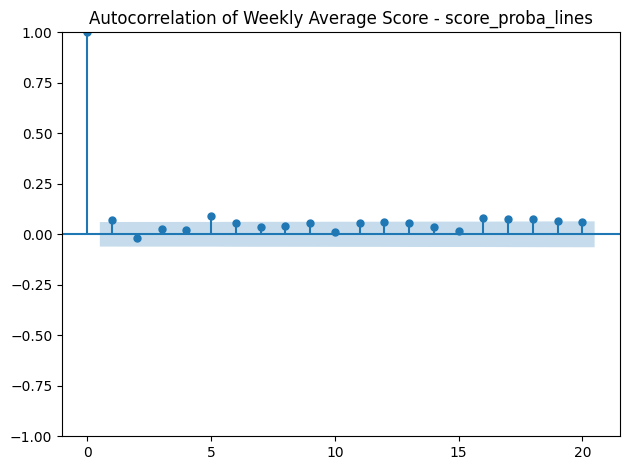

ADF Statistic: -11.176559785045704
p-value: 2.562197077462274e-20
Critical Value (1%): -3.4367023644255537
Critical Value (5%): -2.864344690221488
Critical Value (10%): -2.5682633351736674


C:\Users\vautr\AppData\Local\Temp\ipykernel_7296\3191478825.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



<Figure size 800x400 with 0 Axes>

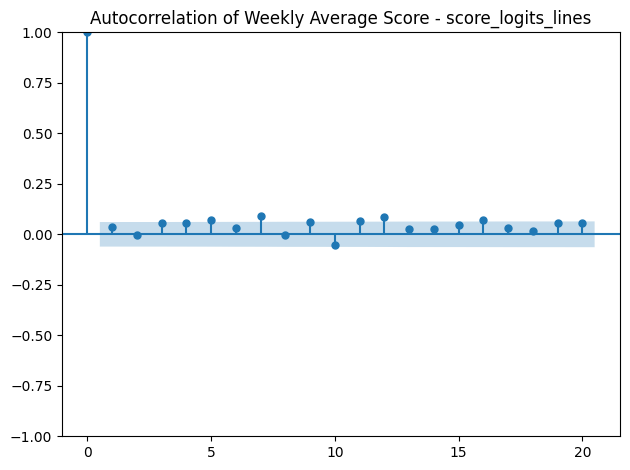

ADF Statistic: -7.374285770578256
p-value: 8.805446594769975e-11
Critical Value (1%): -3.4367396063176874
Critical Value (5%): -2.8643611157329905
Critical Value (10%): -2.5682720836420705


C:\Users\vautr\AppData\Local\Temp\ipykernel_7296\3191478825.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



<Figure size 800x400 with 0 Axes>

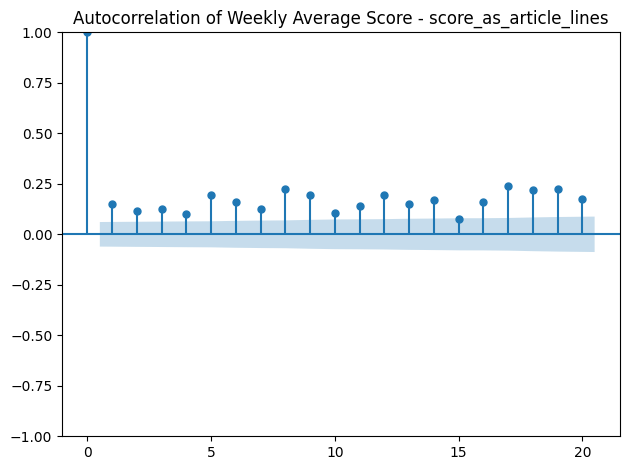

ADF Statistic: -2.2184620466804557
p-value: 0.19961316153995046
Critical Value (1%): -3.436802656106708
Critical Value (5%): -2.8643889233382502
Critical Value (10%): -2.5682868944525388


In [ ]:

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import plotly.graph_objects as go

for name_score in ['score_proba_lines', 'score_logits_lines', 'score_as_article_lines']:
    # Drop NaN weeks
    weekly_avg_clean = creat_average_score(df_score_by_article, name_score=name_score, agreg_freq=agreg_freq).dropna()

    # Compute moving average (e.g., 4-week MA)
    weekly_avg_clean["MA_score"] = weekly_avg_clean[name_score].rolling(window=12).mean()

    # Create the Plotly figure
    fig = go.Figure()

    # Original weekly average score
    fig.add_trace(
        go.Scatter(
            x=weekly_avg_clean["Date_parsed"],
            y=weekly_avg_clean[name_score],
            mode="lines",
            line=dict(width=2, color="royalblue"),
            name="Weekly Average Score"
        )
    )

    # Moving average
    fig.add_trace(
        go.Scatter(
            x=weekly_avg_clean["Date_parsed"],
            y=weekly_avg_clean["MA_score"],
            mode="lines",
            line=dict(width=2, color="orange"),
            name="12-Week Moving Average"
        )
    )

    # Layout
    fig.update_layout(
        title="Weekly Average " + name_score + " Over Time with Moving Average",
        xaxis_title="Week",
        yaxis_title="Average Score",
        template="plotly_white",
        hovermode="x unified"
    )

    fig.show()
    # Plot the ACF
    plt.figure(figsize=(8, 4))
    plot_acf(weekly_avg_clean[name_score], lags=20)
    plt.title("Autocorrelation of Weekly Average Score - " + name_score )
    plt.tight_layout()
    plt.show()

    # Run Augmented Dickey-Fuller test
    result = adfuller(weekly_avg_clean[name_score], regression='c')

    # Extract results
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value}")

In [ ]:
def plot_rolling_ols_evolution(df, y_col, x_cols, window=252, step=1, date_col='Date'):
    """
    Plot l'évolution des coefficients (betas) et p-values d'une régression OLS
    sur une fenêtre glissante dans le temps.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame contenant les données
    y_col : str
        Nom de la colonne dépendante
    x_cols : list
        List des noms de colonnes indépendantes
    window : int
        Taille de la fenêtre glissante (défaut: 252 observations)
    step : int
        Pas du glissement (défaut: 1)
    date_col : str
        Nom de la colonne contenant les dates
    
    Returns:
    --------
    dict contenant les résultats (betas, pvalues, dates)
    """
    
    # Préparer les données
    data = df[[date_col, y_col] + x_cols].copy()
    data = data.dropna()
    data[date_col] = pd.to_datetime(data[date_col])
    data = data.sort_values(date_col).reset_index(drop=True)
    
    # Ajouter une constante
    X = sm.add_constant(data[x_cols])
    y = data[y_col]
    
    # Stocker les résultats
    results_betas = {col: [] for col in x_cols}
    results_pvalues = {col: [] for col in x_cols}
    results_dates = []
    results_r2 = []
    
    # Fenêtre glissante
    for i in range(0, len(data) - window + 1, step):
        window_end = i + window
        
        X_window = X.iloc[i:window_end]
        y_window = y.iloc[i:window_end]
        
        # Régression OLS
        try:
            model = sm.OLS(y_window, X_window).fit()
            
            # Extraire les coefficients et p-values (exclure la constante)
            for j, col in enumerate(x_cols):
                results_betas[col].append(model.params[j + 1])  # +1 pour passer la constante
                results_pvalues[col].append(model.pvalues[j + 1])
            
            results_dates.append(data[date_col].iloc[window_end - 1])
            results_r2.append(model.rsquared)
        except:
            continue
    
    # Créer les plots
    n_vars = len(x_cols)
    fig, axes = plt.subplots(n_vars, 2, figsize=(16, 4 * n_vars))
    
    if n_vars == 1:
        axes = axes.reshape(1, -1)
    
    for idx, col in enumerate(x_cols):
        # Plot Betas
        axes[idx, 0].plot(results_dates, results_betas[col], linewidth=2, marker='o', markersize=3, alpha=0.7)
        axes[idx, 0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
        axes[idx, 0].set_title(f'Évolution du Beta - {col}', fontsize=12, fontweight='bold')
        axes[idx, 0].set_xlabel('Date')
        axes[idx, 0].set_ylabel('Beta')
        axes[idx, 0].grid(True, alpha=0.3)
        axes[idx, 0].tick_params(axis='x', rotation=45)
        
        # Plot P-values
        axes[idx, 1].plot(results_dates, results_pvalues[col], linewidth=2, marker='o', markersize=3, alpha=0.7, color='orange')
        axes[idx, 1].axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='Seuil 5%')
        axes[idx, 1].fill_between(results_dates, 0, 0.05, alpha=0.2, color='green', label='Significatif')
        axes[idx, 1].set_title(f'P-value - {col}', fontsize=12, fontweight='bold')
        axes[idx, 1].set_xlabel('Date')
        axes[idx, 1].set_ylabel('P-value')
        axes[idx, 1].set_ylim([0, 1])
        axes[idx, 1].grid(True, alpha=0.3)
        axes[idx, 1].legend()
        axes[idx, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

C:\Users\vautr\AppData\Local\Temp\ipykernel_7296\3191478825.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



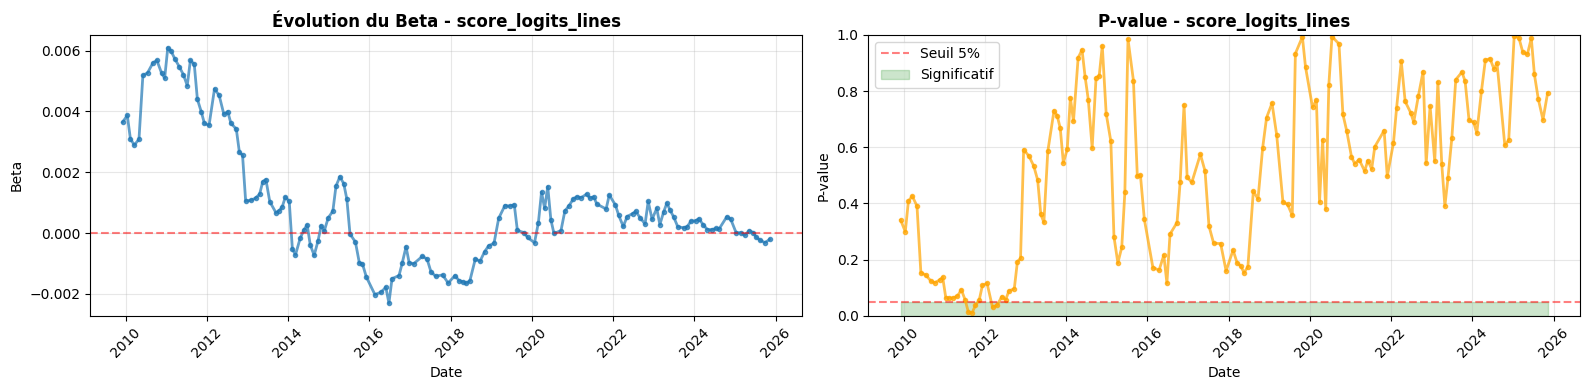

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

name_score = 'score_logits_lines' # 'score_proba_lines', 'score_logits_lines', 'score_as_article_lines'
agreg_freq = "W"
weekly_avg_clean = creat_average_score(df_score_by_article, name_score=name_score, agreg_freq=agreg_freq)
df_sentiment_returns = get_aligned_returns("^STOXX50E", freq=agreg_freq, ref_df=weekly_avg_clean)
df_sentiment_returns.dropna(subset=["Return", name_score], inplace=True)
plot_rolling_ols_evolution(
    df_sentiment_returns,
    y_col="Return",
    x_cols=[name_score],
    window=104,
    step=4,    
    date_col="Date_parsed"
)

In [ ]:
sx5e_returns

,Date_parsed,score_proba,article_count,date_return,Return,score_proba_lag1,score_proba_lag2,score_proba_lag3,score_proba_lag4,score_proba_lag5,return_lag1
0,1997-04-27,0.000000,1,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1997-05-04,0.000000,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1997-05-11,0.000000,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1997-05-18,0.000000,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1997-05-25,0.000000,0,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
1485,2025-10-12,-0.756039,1,2025-10-19,0.013753,0.000000,-0.805704,0.670356,-0.686089,0.000000,-0.021302
1486,2025-10-19,0.000000,1,2025-10-26,0.011968,-0.756039,0.000000,-0.805704,0.670356,-0.686089,0.013753
1487,2025-10-26,0.000000,0,2025-11-02,-0.002196,0.000000,-0.756039,0.000000,-0.805704,0.670356,0.011968
1488,2025-11-02,0.002740,6,2025-11-09,-0.016869,0.000000,0.000000,-0.756039,0.000000,-0.805704,-0.002196


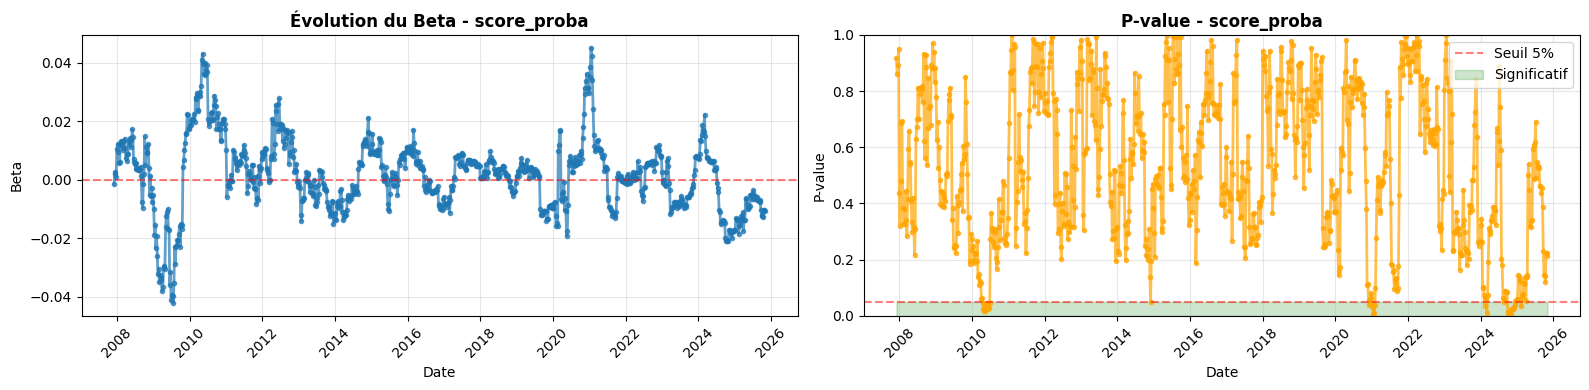

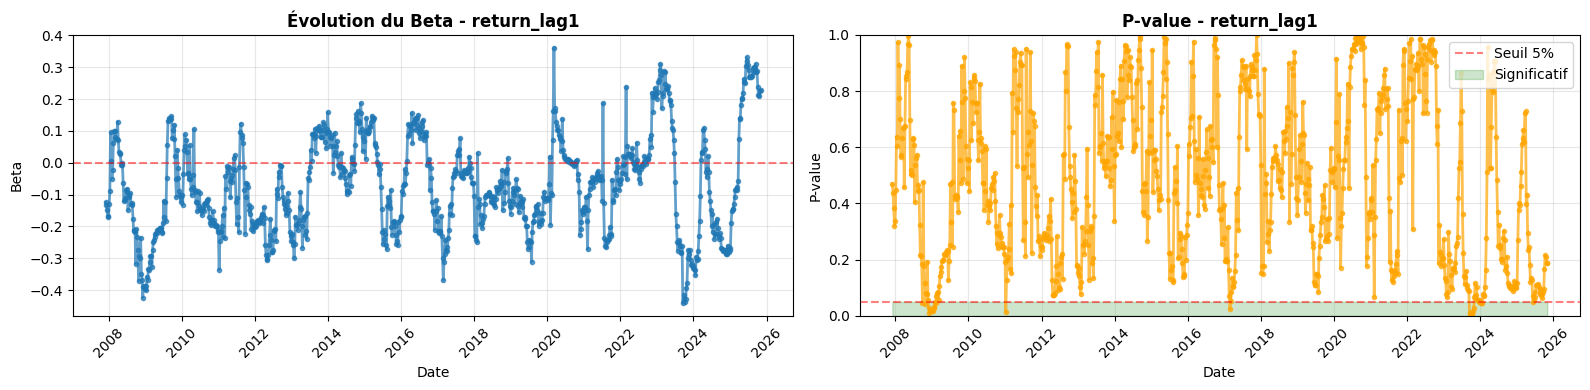

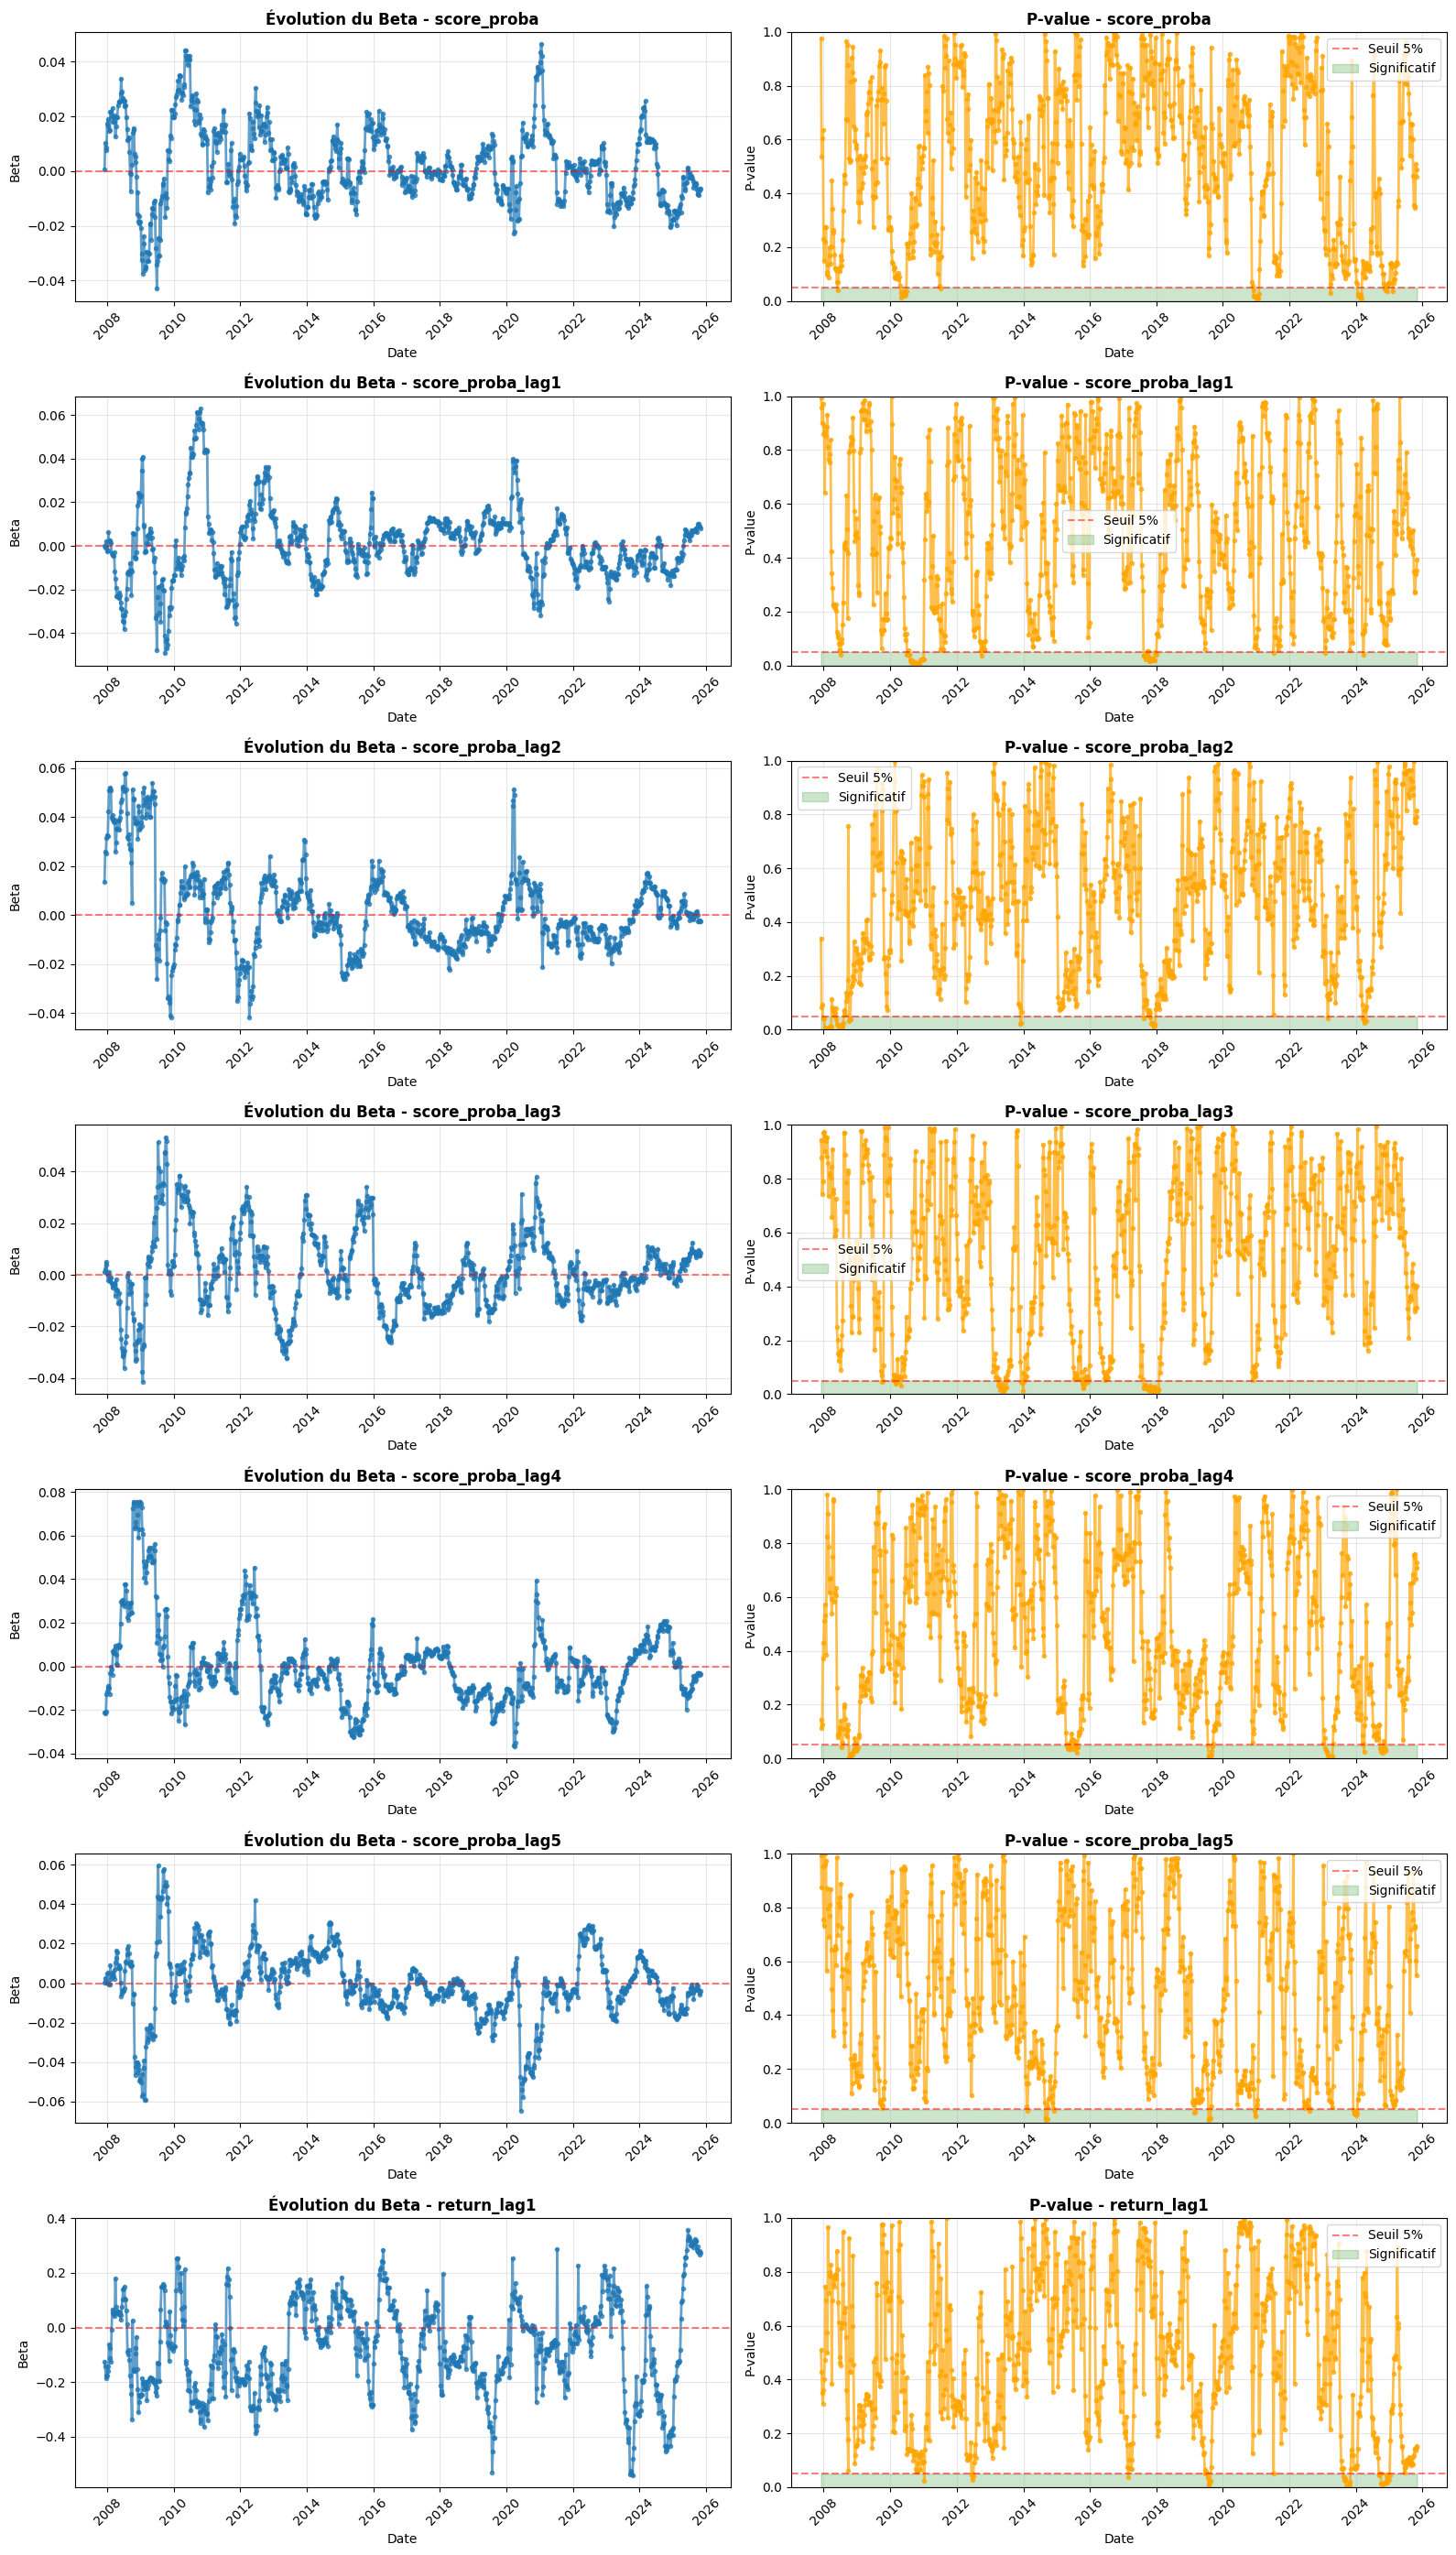

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
# Exemple d'utilisation
plot_rolling_ols_evolution(
     df = sx5e_returns.dropna(subset=["Return", name_score] ),
     y_col='Return',
     x_cols= [name_score],
     window=36,  # Fenêtre de 52 observations
     step=1,
     date_col= 'Date_parsed'
 )

plot_rolling_ols_evolution(
     df = sx5e_returns.dropna(subset=["Return", name_score] ),
     y_col='Return',
     x_cols= ['return_lag1'],
     window=36,  # Fenêtre de 52 observations
     step=1,
     date_col= 'Date_parsed'
 )
# Exemple d'utilisation
plot_rolling_ols_evolution(
     df = sx5e_returns.dropna(subset=["Return"] + list_features),
     y_col='Return',
     x_cols=list_features,
     window=36,  # Fenêtre de 52 observations
     step=1,
     date_col= 'Date_parsed'
 )

In [ ]:
import plotly.graph_objects as go

# Drop NaN weeks
weekly_avg_clean = weekly_avg.dropna(subset=['score_as_article'])

# Create the Plotly figure
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=weekly_avg_clean["Date_parsed"],
        y=weekly_avg_clean[name_score],
        mode="lines",  # line only, no markers
        line=dict(width=2, color="royalblue"),
        name="Weekly Average Score"
    )
)

# Layout
fig.update_layout(
    title="Weekly Average Score Over Time",
    xaxis_title="Week",
    yaxis_title="Average Score",
    template="plotly_white",
    hovermode="x unified"
)

fig.show()


KeyError: ['score_as_article']

<Figure size 800x400 with 0 Axes>

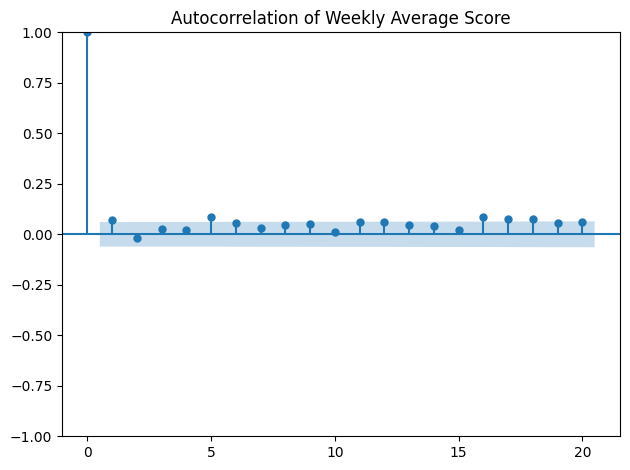

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
# Drop NaN weeks
weekly_avg_clean = weekly_avg.dropna(subset=[name_score])

# Plot the ACF
plt.figure(figsize=(8, 4))
plot_acf(weekly_avg_clean[name_score], lags=20)
plt.title("Autocorrelation of Weekly Average Score")
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Drop NaN values just in case
weekly_avg_clean = weekly_avg.dropna(subset=[name_score])

# Run Augmented Dickey-Fuller test
result = adfuller(weekly_avg_clean[name_score], regression='c')

# Extract results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")

ADF Statistic: -11.220143799068182
p-value: 2.023044335470735e-20
Critical Value (1%): -3.4366961996098264
Critical Value (5%): -2.8643419712141074
Critical Value (10%): -2.5682618869934934


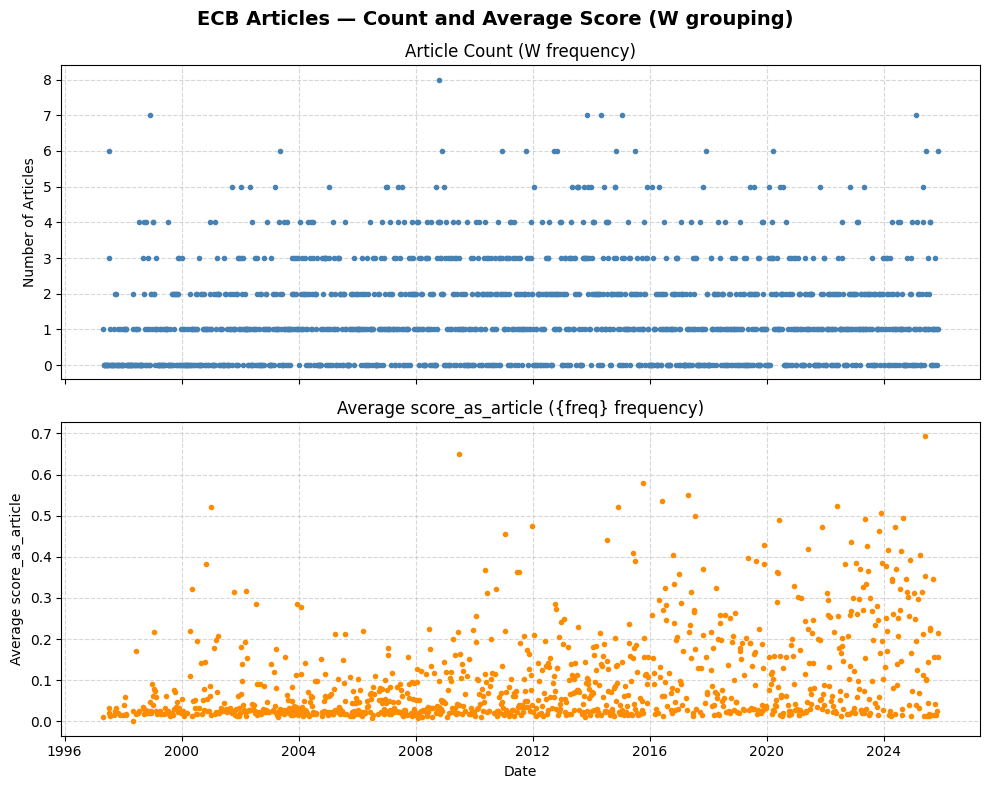

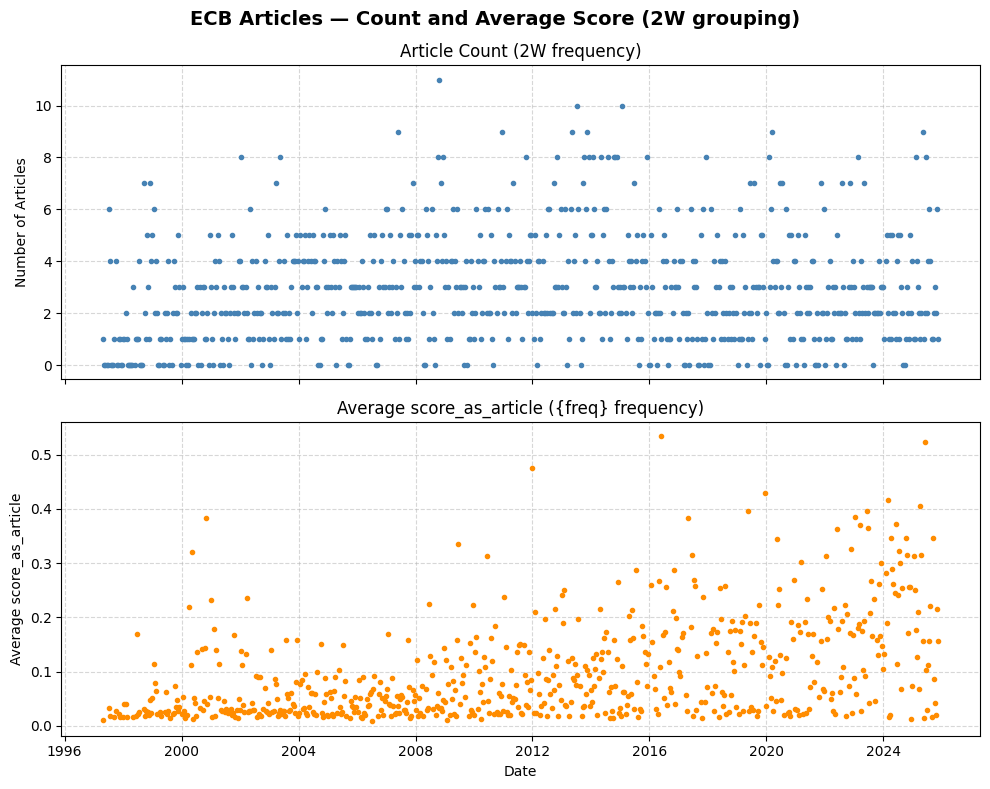

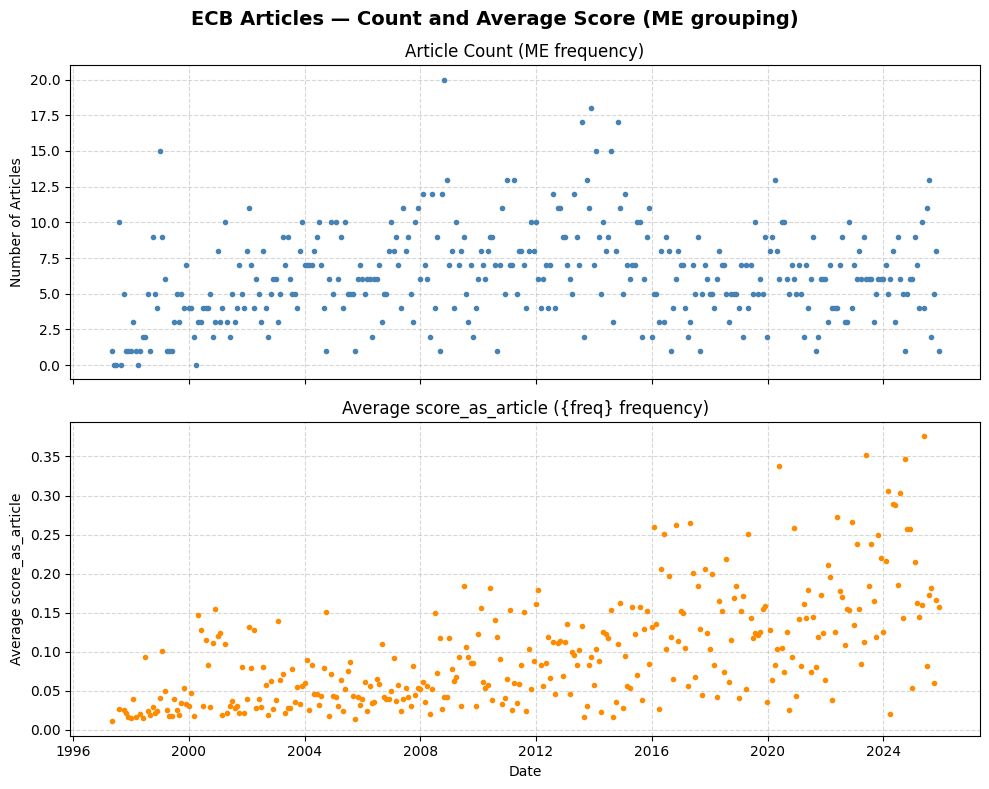

In [ ]:
def plot_article_stats(article_df, freq="W", name_score="score_as_article"):
    """
    Compute and plot article statistics (count & average random score)
    grouped by a chosen time frequency.
    
    Parameters
    ----------
    article_df : pd.DataFrame
        Must contain columns "Date" (e.g. "5 November 2025") and "random_score".
    freq : str, optional
        Time frequency for grouping.
        Examples:
            'W'  -> weekly (default)
            '2W' -> biweekly
            'M'  -> monthly
    
    Returns
    -------
    weekly_avg : pd.DataFrame
        DataFrame with Date_parsed, average score, and article count.
    fig : matplotlib.figure.Figure
        Figure object with the two subplots.
    """

    # --- Data preparation ---
    df = article_df.copy()
    df["Date_parsed"] = pd.to_datetime(df["Date"], format="%d %B %Y")

    # --- Aggregation ---
    grouped = (
        df.groupby(pd.Grouper(key="Date_parsed", freq=freq))
        .agg(
            **{
                name_score: (name_score, "mean"),
                "article_count": (name_score, "count")
            }
        )
        .reset_index()
    )

    # --- Plot ---
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot 1: number of articles per period
    ax[0].plot(grouped["Date_parsed"], grouped["article_count"],
               color="steelblue", marker=".", linestyle="")
    ax[0].set_ylabel("Number of Articles")
    ax[0].set_title(f"Article Count ({freq} frequency)")
    ax[0].grid(True, linestyle="--", alpha=0.5)

    # Plot 2: average score per period
    ax[1].plot(grouped["Date_parsed"], grouped[name_score],
               color="darkorange", marker=".", linestyle="")
    ax[1].set_ylabel("Average " + name_score)
    ax[1].set_title(f"Average " + name_score + " ({freq} frequency)")
    ax[1].grid(True, linestyle="--", alpha=0.5)

    # Common labels and layout
    fig.suptitle(f"ECB Articles — Count and Average Score ({freq} grouping)",
                 fontsize=14, fontweight="bold")
    plt.xlabel("Date")
    plt.tight_layout()

    return grouped, fig


weekly_stats_w, fig_weekly_w = plot_article_stats(article_list, freq="W")
weekly_stats_2w, fig_weekly_2w = plot_article_stats(article_list, freq="2W")
weekly_stats_m, fig_weekly_m = plot_article_stats(article_list, freq="ME")